In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================
# 1. LOAD DATA
# ============================================
print("="*60)
print("LOADING DATA")
print("="*60)

df = pd.read_csv('games_early.csv')


print(f"Original Dataset Shape: {df.shape}")
print(f"\nRound Distribution:")
print(df['round'].value_counts())
print(f"\nTarget Variable Distribution:")
print(df['win'].value_counts())
print(f"Win Rate: {df['win'].mean():.2%}")

# ============================================
# 2. PREPARE FEATURES (EXCLUDING SEEDS)
# ============================================
print("\n" + "="*60)
print("PREPARING FEATURES")
print("="*60)

exclude_cols = ['year', 'region', 'round',
                'high_bracket_team', 'low_bracket_team', 'win',
                'high_bracket_seed', 'low_bracket_seed']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols].copy()
y = df['win'].copy()

# Clean data
X = X.select_dtypes(include=[np.number])
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.median(), inplace=True)

print(f"Feature Matrix Shape: {X.shape}")
print(f"Number of Features: {X.shape[1]}")

# ============================================
# 3. TRAIN/TEST SPLIT
# ============================================
print("\n" + "="*60)
print("TRAIN/TEST SPLIT")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=100, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training win rate: {y_train.mean():.2%}")
print(f"Test win rate: {y_test.mean():.2%}")

LOADING DATA
Original Dataset Shape: (480, 27)

Round Distribution:
round
First Round     320
Second Round    160
Name: count, dtype: int64

Target Variable Distribution:
win
0    240
1    240
Name: count, dtype: int64
Win Rate: 50.00%

PREPARING FEATURES
Feature Matrix Shape: (480, 19)
Number of Features: 19

TRAIN/TEST SPLIT
Training set size: 380
Test set size: 100
Training win rate: 50.00%
Test win rate: 50.00%



EXPLORATORY DATA ANALYSIS

--- Top 10 Features Correlated with Winning ---
  Feature  Correlation
      wab     0.671545
   adj_oe     0.597058
   adj_de     0.591591
  barthag     0.585700
  drb_pct     0.302036
  orb_pct     0.301116
  efg_pct     0.242517
   2p_pct     0.241394
adj_tempo     0.235698
  2pd_pct     0.229523


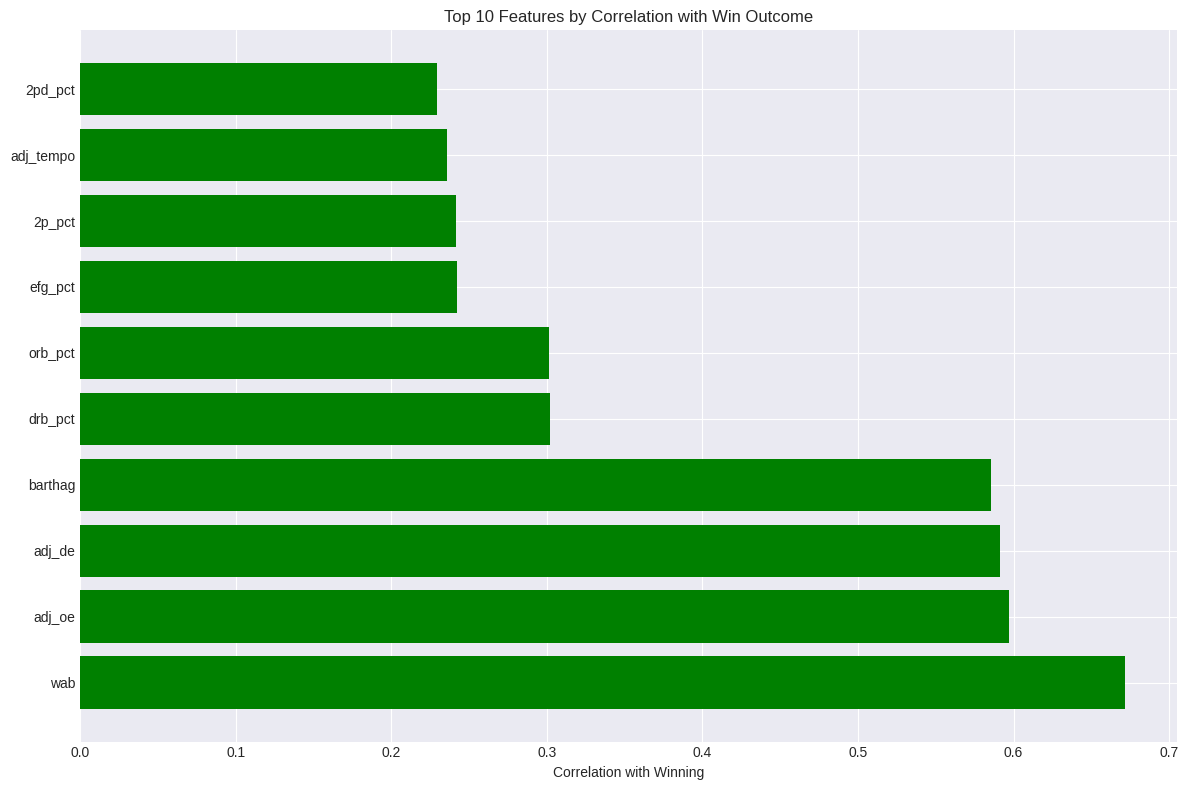

In [8]:
# ============================================
# 4. EXPLORATORY DATA ANALYSIS
# ============================================
print("\n" + "="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

# Feature correlations with target (using training data only)
print("\n--- Top 10 Features Correlated with Winning ---")
correlations = pd.DataFrame({
    'Feature': X_train.columns,
    'Correlation': [X_train[col].corr(y_train) for col in X_train.columns]
})
correlations['Abs_Correlation'] = correlations['Correlation'].abs()
top_correlations = correlations.nlargest(10, 'Abs_Correlation')
print(top_correlations[['Feature', 'Correlation']].to_string(index=False))

# Plot 1: Top correlations
plt.figure(figsize=(12, 8))
top_10 = correlations.nlargest(10, 'Abs_Correlation')
colors = ['green' if x > 0 else 'red' for x in top_10['Correlation']]
plt.barh(range(len(top_10)), top_10['Correlation'], color=colors)
plt.yticks(range(len(top_10)), top_10['Feature'])
plt.xlabel('Correlation with Winning')
plt.title('Top 10 Features by Correlation with Win Outcome')
plt.tight_layout()
plt.show()

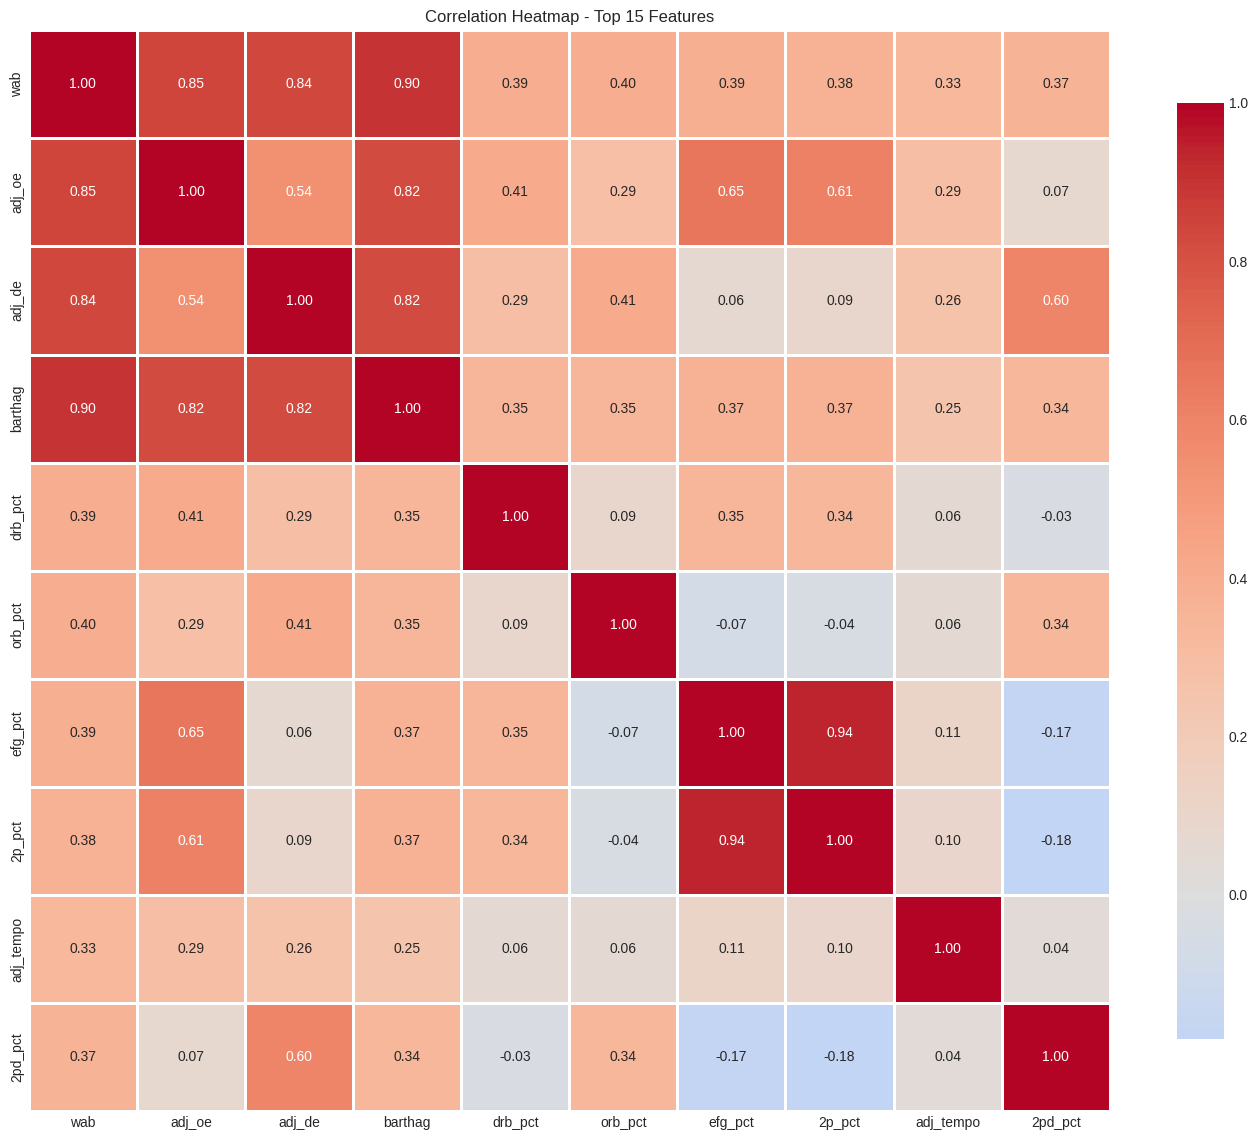

In [9]:
# Plot 2: Feature correlation heatmap (top features)
plt.figure(figsize=(14, 12))
top_features = top_10['Feature'].head(15).tolist()
corr_matrix = X_train[top_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap - Top 15 Features')
plt.tight_layout()
plt.show()

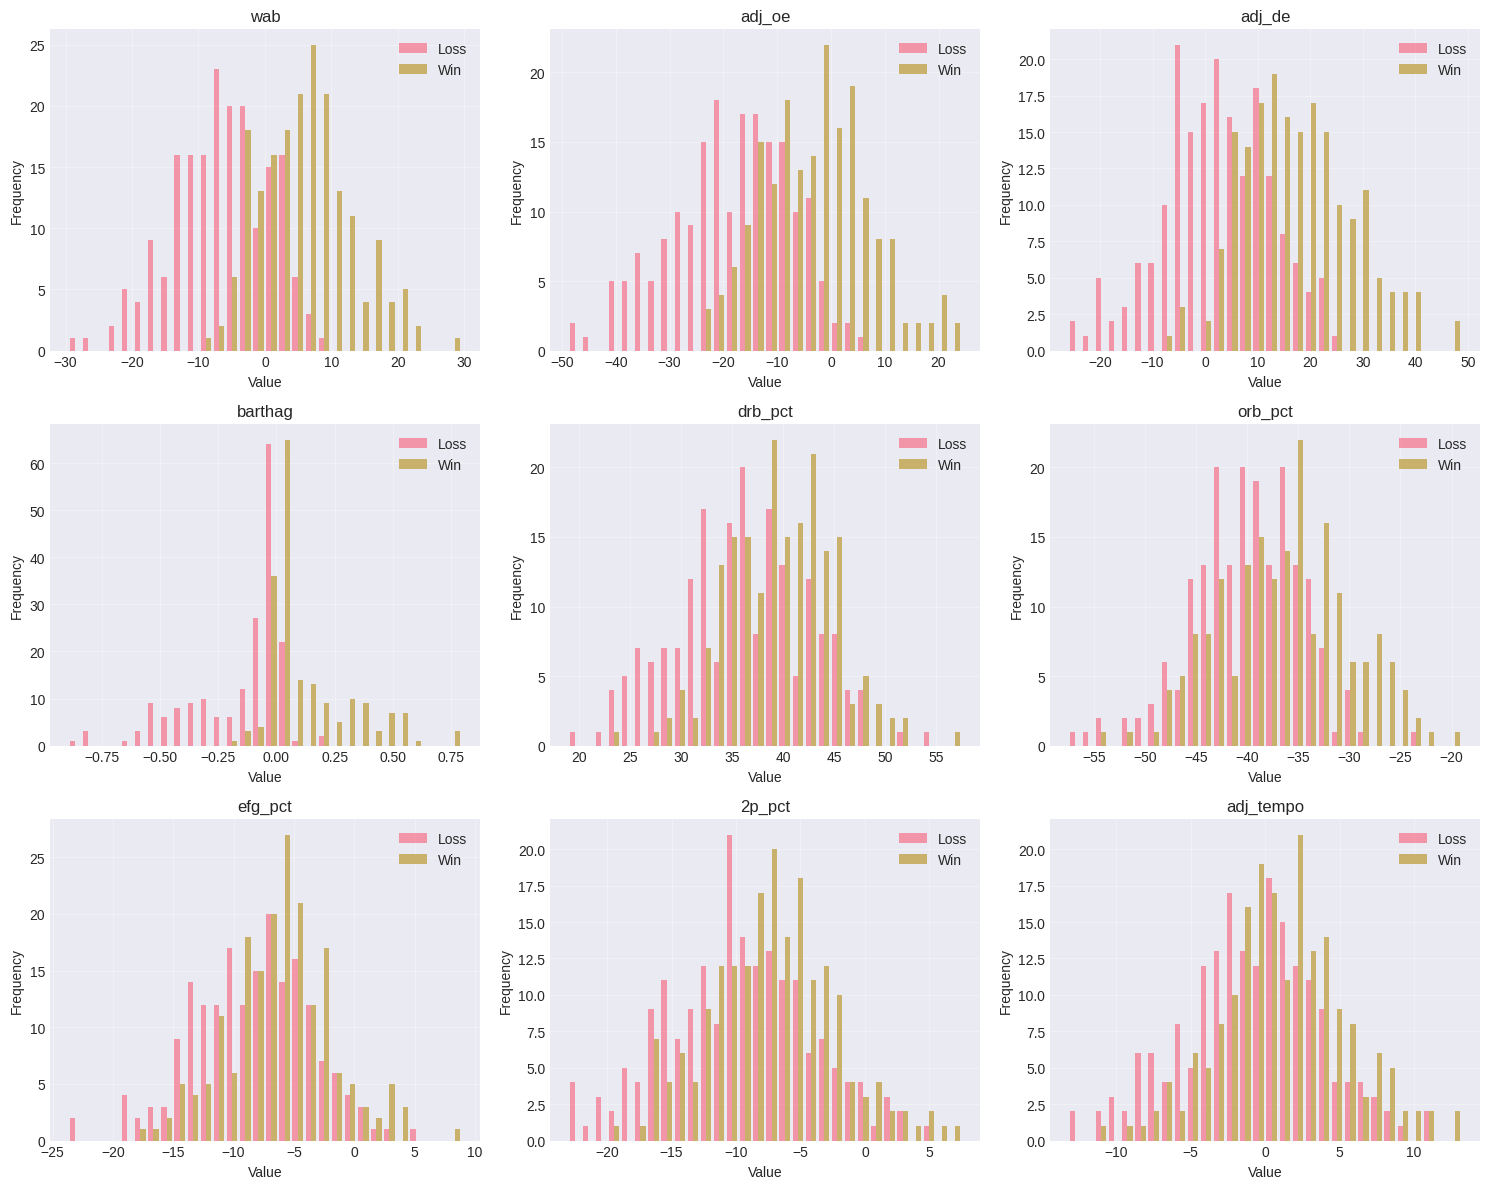

In [10]:
# Plot 3: Feature distributions for top features
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, feat in enumerate(top_features[:9]):
    axes[idx].hist([X_train[feat][y_train==0], X_train[feat][y_train==1]],
                  bins=30, alpha=0.7, label=['Loss', 'Win'])
    axes[idx].set_title(f'{feat}')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Statistical summary
print("\n--- Statistical Summary of Top 10 Features ---")
print(X_train[top_features[:10]].describe().T[['mean', 'std', 'min', 'max']])


--- Statistical Summary of Top 10 Features ---
                mean        std      min      max
wab        -0.248921   9.501818 -29.6000  29.6000
adj_oe    -10.571842  13.039359 -48.8000  24.3000
adj_de      9.841842  12.930899 -26.0000  48.8000
barthag    -0.010272   0.243445  -0.8929   0.7952
drb_pct    37.823947   6.170688  19.0000  57.5000
orb_pct   -38.141053   6.160663 -57.5000 -19.0000
efg_pct    -7.251842   4.773179 -23.7000   8.9000
2p_pct     -8.516842   5.425244 -23.0000   7.5000
adj_tempo   0.175789   4.525564 -13.2000  13.2000
2pd_pct     8.465789   5.345349  -7.5000  23.0000


In [12]:
# ============================================
# 5. FEATURE SELECTION METHODS (ON TRAINING DATA) - TOP 10
# ============================================
print("\n" + "="*60)
print("FEATURE SELECTION METHODS - TOP 10")
print("="*60)

# 5.1 Univariate Feature Selection (ANOVA F-test)
print("\n--- Univariate Feature Selection (ANOVA F-test) ---")
k = 10
selector_uni = SelectKBest(score_func=f_classif, k=k)
selector_uni.fit(X_train, y_train)

univariate_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'Score': selector_uni.scores_,
    'P_value': selector_uni.pvalues_
}).sort_values('Score', ascending=False)

univariate_features = univariate_scores.head(k)['Feature'].tolist()
print(f"\nTop {k} features selected:")
print(univariate_scores.head(k)[['Feature', 'Score']].to_string(index=False))



FEATURE SELECTION METHODS - TOP 10

--- Univariate Feature Selection (ANOVA F-test) ---

Top 10 features selected:
  Feature      Score
      wab 310.490861
   adj_oe 209.392489
   adj_de 203.520961
  barthag 197.381289
  drb_pct  37.944870
  orb_pct  37.691051
  efg_pct  23.621128
   2p_pct  23.389295
adj_tempo  22.234494
  2pd_pct  21.020660


In [13]:
# 5.2 Mutual Information Feature Selection
print("\n--- Mutual Information Feature Selection ---")
selector_mi = SelectKBest(score_func=mutual_info_classif, k=k)
selector_mi.fit(X_train, y_train)

mi_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'MI_Score': selector_mi.scores_
}).sort_values('MI_Score', ascending=False)

mi_features = mi_scores.head(k)['Feature'].tolist()
print(f"\nTop {k} features selected:")
print(mi_scores.head(k).to_string(index=False))


--- Mutual Information Feature Selection ---

Top 10 features selected:
 Feature  MI_Score
     wab  0.370574
 barthag  0.323120
  adj_oe  0.268553
  adj_de  0.249659
 orb_pct  0.066389
 efg_pct  0.062118
efgd_pct  0.048968
 drb_pct  0.048965
    ftrd  0.048086
     ftr  0.029875



--- Random Forest Feature Importance ---

Top 10 features by importance:
 Feature  Importance
 barthag    0.197300
     wab    0.187626
  adj_oe    0.118731
  adj_de    0.079229
 orb_pct    0.043096
 drb_pct    0.036248
efgd_pct    0.031995
     3pr    0.027892
    ftrd    0.027302
     tor    0.026986


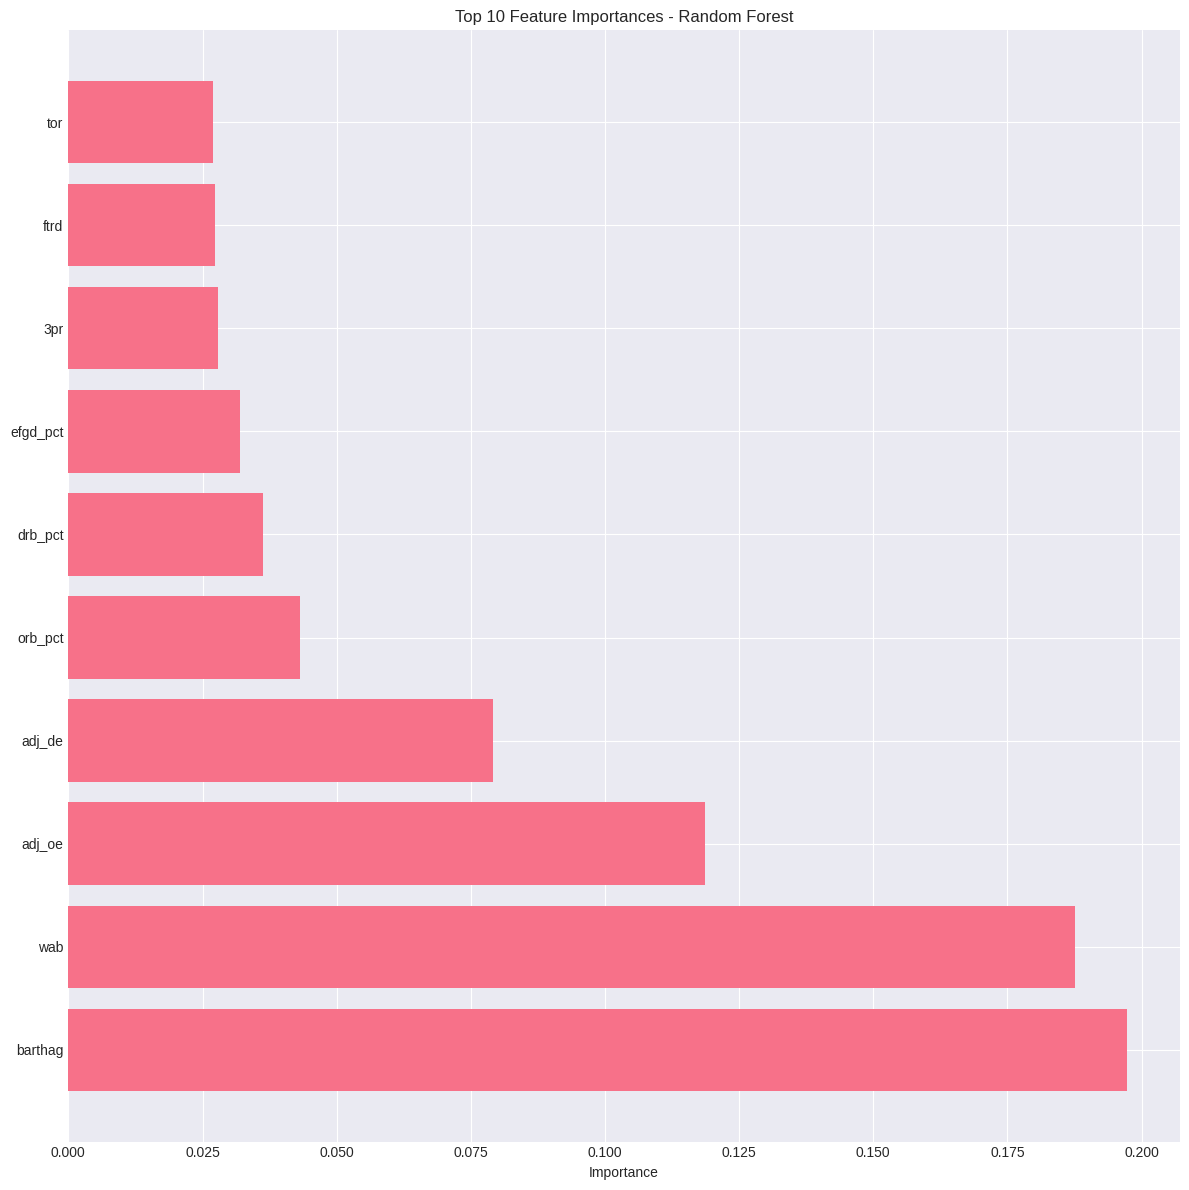

In [15]:

# 5.3 Random Forest Feature Importance
print("\n--- Random Forest Feature Importance ---")
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_train, y_train)

rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_selector.feature_importances_
}).sort_values('Importance', ascending=False)

rf_top_features = rf_importance.head(10)['Feature'].tolist()
print(f"\nTop 10 features by importance:")
print(rf_importance.head(10).to_string(index=False))

# Plot RF feature importance
plt.figure(figsize=(12, 12))
top_10_rf = rf_importance.head(10)
plt.barh(range(len(top_10_rf)), top_10_rf['Importance'])
plt.yticks(range(len(top_10_rf)), top_10_rf['Feature'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()


--- Logistic Regression Feature Importance ---

Top 10 features by importance:
 Feature  Importance
     wab    0.978504
  adj_oe    0.727420
  adj_de    0.706359
 drb_pct    0.006334
 barthag    0.000000
efgd_pct    0.000000
 efg_pct    0.000000
     tor    0.000000
    tord    0.000000
 orb_pct    0.000000


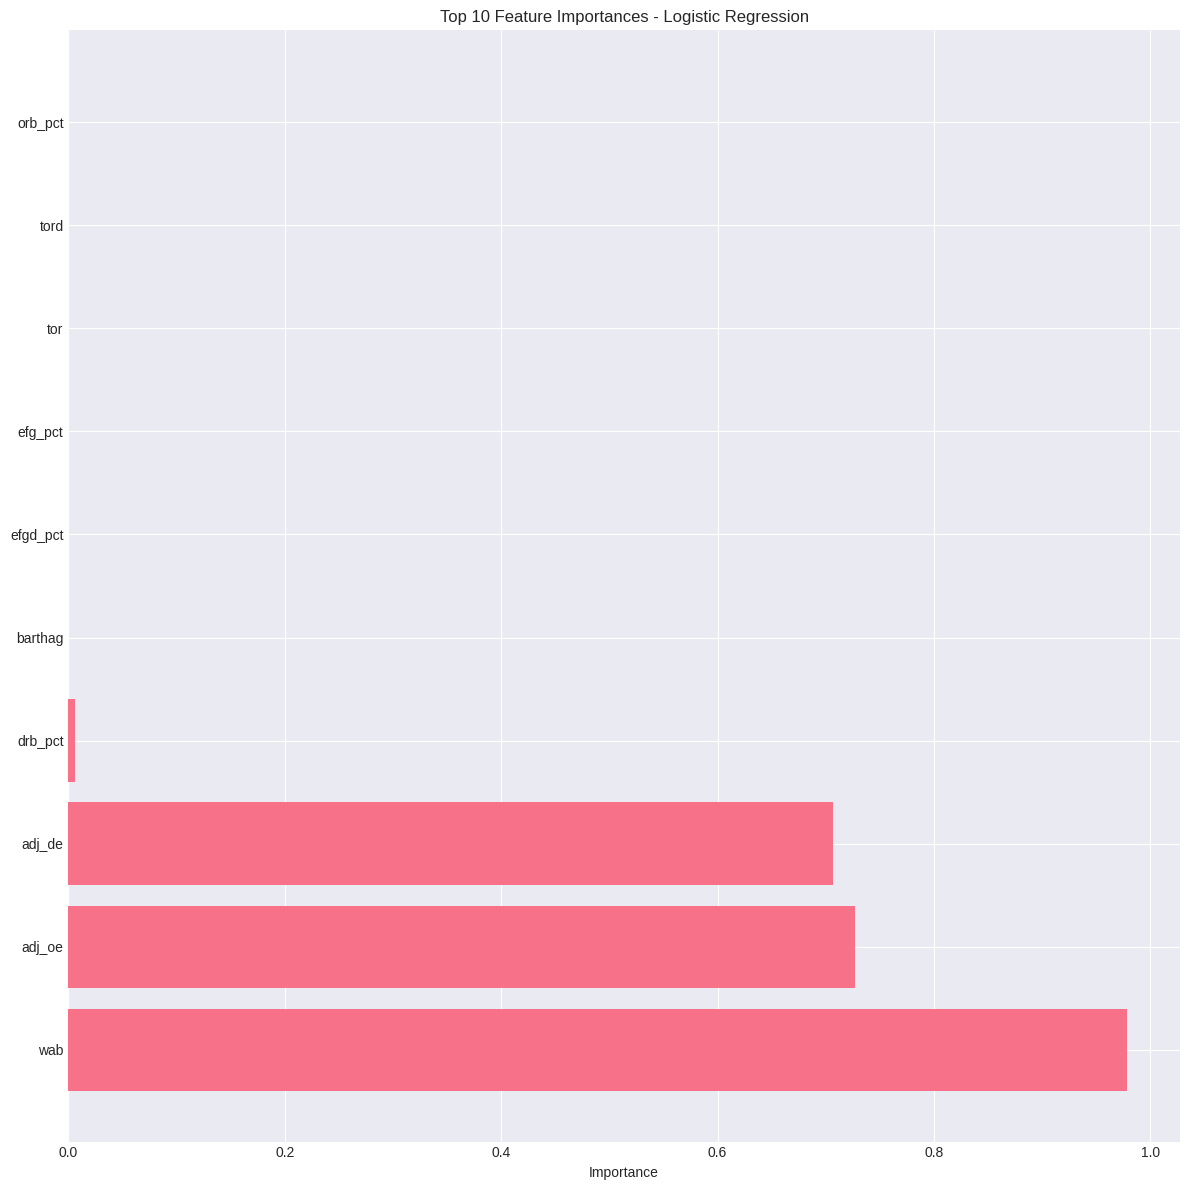

In [17]:
# 5.4 Logistic Regression Feature Importance
print("\n--- Logistic Regression Feature Importance ---")
scaler_temp = StandardScaler()
X_train_scaled_temp = scaler_temp.fit_transform(X_train)

lr_selector = LogisticRegression(max_iter=1000, random_state=42, penalty='l1',
                                 solver='liblinear', C=0.1)
lr_selector.fit(X_train_scaled_temp, y_train)

lr_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(lr_selector.coef_[0])
}).sort_values('Importance', ascending=False)

lr_top_features = lr_importance.head(10)['Feature'].tolist()
print(f"\nTop 10 features by importance:")
print(lr_importance.head(10).to_string(index=False))

# Plot LR feature importance
plt.figure(figsize=(12, 12))
top_10_lr = lr_importance.head(10)
plt.barh(range(len(top_10_lr)), top_10_lr['Importance'])
plt.yticks(range(len(top_10_lr)), top_10_lr['Feature'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances - Logistic Regression')
plt.tight_layout()
plt.show()


In [18]:
# 5.5 Recursive Feature Elimination (RFE)
print("\n--- Recursive Feature Elimination (RFE) ---")
rfe_estimator = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
selector_rfe = RFE(estimator=rfe_estimator, n_features_to_select=10, step=5)
selector_rfe.fit(X_train, y_train)

rfe_rankings = pd.DataFrame({
    'Feature': X_train.columns,
    'Ranking': selector_rfe.ranking_,
    'Selected': selector_rfe.support_
}).sort_values('Ranking')

rfe_features = rfe_rankings[rfe_rankings['Selected']]['Feature'].tolist()
print(f"\nTop 10 features selected:")
print(rfe_rankings.head(10)[['Feature', 'Ranking']].to_string(index=False))

# Top correlation features
correlation_features = correlations.nlargest(10, 'Abs_Correlation')['Feature'].tolist()


--- Recursive Feature Elimination (RFE) ---

Top 10 features selected:
  Feature  Ranking
      wab        1
  barthag        1
   adj_oe        1
   adj_de        1
   2p_pct        1
  2pd_pct        1
  drb_pct        1
  orb_pct        1
adj_tempo        1
      3pr        1


In [19]:
# ============================================
# 6. MODEL COMPARISON WITH DIFFERENT FEATURE SETS
# ============================================
print("\n" + "="*60)
print("MODEL COMPARISON WITH DIFFERENT FEATURE SETS")
print("="*60)

# Define feature sets
feature_sets = {
    'Top_40_Correlation': correlation_features,
    'Univariate_F_Test': univariate_features,
    'Mutual_Information': mi_features,
    'RF_Importance': rf_top_features,
    'LR_Importance': lr_top_features,
    'RFE_Selected': rfe_features,
    'All_Features': X_train.columns.tolist()
}

results_summary = []

for set_name, features in feature_sets.items():
    print(f"\n{'#'*60}")
    print(f"FEATURE SET: {set_name} ({len(features)} features)")
    print(f"{'#'*60}")

    # Prepare data subsets
    X_train_subset = X_train[features]
    X_test_subset = X_test[features]

    # Scale for Logistic Regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_subset)
    X_test_scaled = scaler.transform(X_test_subset)

    # === Random Forest ===
    print(f"\n--- Random Forest - {set_name} ---")
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=3,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train_subset, y_train)

    # RF Predictions
    rf_y_pred = rf_model.predict(X_test_subset)
    rf_y_pred_proba = rf_model.predict_proba(X_test_subset)[:, 1]

    # RF Metrics
    rf_accuracy = accuracy_score(y_test, rf_y_pred)
    rf_cv_scores = cross_val_score(rf_model, X_train_subset, y_train, cv=5, scoring='accuracy')
    rf_cv_mean = rf_cv_scores.mean()
    rf_cv_std = rf_cv_scores.std()

    try:
        rf_auc = roc_auc_score(y_test, rf_y_pred_proba)
    except:
        rf_auc = None

    print(f"Test Accuracy: {rf_accuracy:.4f}")
    print(f"Cross-Validation Accuracy: {rf_cv_mean:.4f} (+/- {rf_cv_std:.4f})")
    if rf_auc:
        print(f"ROC AUC Score: {rf_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, rf_y_pred, target_names=['Loss', 'Win']))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, rf_y_pred))

    # === Logistic Regression ===
    print(f"\n--- Logistic Regression - {set_name} ---")
    lr_model = LogisticRegression(
        max_iter=1000,
        random_state=42,
        C=1.0,
        penalty='l2'
    )
    lr_model.fit(X_train_scaled, y_train)

    # LR Predictions
    lr_y_pred = lr_model.predict(X_test_scaled)
    lr_y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

    # LR Metrics
    lr_accuracy = accuracy_score(y_test, lr_y_pred)
    lr_cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    lr_cv_mean = lr_cv_scores.mean()
    lr_cv_std = lr_cv_scores.std()

    try:
        lr_auc = roc_auc_score(y_test, lr_y_pred_proba)
    except:
        lr_auc = None

    print(f"Test Accuracy: {lr_accuracy:.4f}")
    print(f"Cross-Validation Accuracy: {lr_cv_mean:.4f} (+/- {lr_cv_std:.4f})")
    if lr_auc:
        print(f"ROC AUC Score: {lr_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, lr_y_pred, target_names=['Loss', 'Win']))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, lr_y_pred))

    # Store results
    results_summary.append({
        'Feature_Set': set_name,
        'Num_Features': len(features),
        'RF_Test_Accuracy': rf_accuracy,
        'RF_CV_Mean': rf_cv_mean,
        'RF_CV_Std': rf_cv_std,
        'LR_Test_Accuracy': lr_accuracy,
        'LR_CV_Mean': lr_cv_mean,
        'LR_CV_Std': lr_cv_std
    })



MODEL COMPARISON WITH DIFFERENT FEATURE SETS

############################################################
FEATURE SET: Top_40_Correlation (10 features)
############################################################

--- Random Forest - Top_40_Correlation ---
Test Accuracy: 0.8200
Cross-Validation Accuracy: 0.8105 (+/- 0.0359)
ROC AUC Score: 0.8984

Classification Report:
              precision    recall  f1-score   support

        Loss       0.83      0.80      0.82        50
         Win       0.81      0.84      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100


Confusion Matrix:
[[40 10]
 [ 8 42]]

--- Logistic Regression - Top_40_Correlation ---
Test Accuracy: 0.8500
Cross-Validation Accuracy: 0.8105 (+/- 0.0445)
ROC AUC Score: 0.9060

Classification Report:
              precision    recall  f1-score   support

        Loss       0.86      0.84      0.